In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
scaler = StandardScaler()
import seaborn as sns
# import matplotlib as plt
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [ ]:
# load ED_with_indicators.csv
orig_df = pd.read_csv('../data/ED_2008-17_with_MC_female.csv')

In [4]:
POSSIBLE_RELEVANT_COLS = ['Encounter_Type', 'Age_Group_Num', 'Age_Group',
       'Admission_Type', 'Admission_Source', 'ER_Flag',
       'Observation_Stay_Flag', 'Admission_Year', 'Admission_Quarter',
       'Admission_Hour', 'LOS_Days', 'LOS_Hours', 'Patient_Discharge_Status',
       'Patient_Marital_Status', 'pop', 'pctgqtract', 'LEB', 'hpi', 'economic',
       'education', 'insurance', 'clean_enviro', 'housing', 'neighborhood',
       'social', 'transportation', 'abovepoverty', 'automobile', 'bachelorsed',
       'bikeaccess', 'censusresponse', 'dieselpm', 'employed', 'homeownership',
       'houserepair', 'inhighschool', 'inpreschool', 'insured', 'ownsevere',
       'parkaccess_ut', 'percapitaincome', 'pm25', 'rentsevere', 'treecanopy',
       'uncrowded', 'voting', 'latino_pct', 'white_pct', 'black_pct',
       'asian_pct', 'multiple_pct', 'NativeAm_pct', 'PacificIsl_pct',
       'other_pct', 'lat', 'lng', 'Maternal_Complications_Indicator',
       'high_risk_pregnancy', 'prev_C-section', 'mult_gestation', 'prolonged_pregnancy']

POSSIBLE_RELEVANT_COLS_5 = ['Admission_Type', 
                            'Admission_Quarter',
                            'Admission Hour',
                            'prev_C-section', 
                            'high_risk_pregnancy',
                            'mult_gestation', 
                            'prolonged_pregnancy', 
                            'Encounter_Type',
                            'Age_Group', 
                            'Admission_Source',
                            'Patient_Marital_Status',
                            'Maternal_Complications_Indicator']

def filter_df(df, columns_to_keep):
       columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
       df.drop(columns=columns_to_drop, inplace=True)
       df.dropna(axis=0, inplace=True)

       return df

In [5]:
def get_X_y(df):
    X_unprocessed = df.drop(columns=['Maternal_Complications_Indicator'])
    y = df['Maternal_Complications_Indicator']

    categorical_feats = []
    for col in X_unprocessed.columns:
        if X_unprocessed[col].dtype == 'object':
            categorical_feats.append(col)
            
    X = pd.get_dummies(X_unprocessed, columns=categorical_feats, drop_first=True)
    
    return X, y

In [6]:
def train(X, y, scaled=True, parameters=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
    indices_to_drop = y_train[y_train == 0].index

    num_positive_samples = (y_train == 1).sum()
    num_to_drop = len(indices_to_drop) - num_positive_samples
    indices_to_drop = indices_to_drop.to_series().sample(n=num_to_drop, random_state=42)
    # Drop the selected rows
    y_train = y_train.drop(indices_to_drop)
    X_train = X_train.drop(indices_to_drop)
    
    indices_to_drop_acc = y_test[y_test == 0].index
    indices_to_drop_acc = indices_to_drop_acc.to_series().sample(n=len(indices_to_drop_acc) - (y_test == 1).sum(), random_state=42)
    X_test_acc = X_test.drop(indices_to_drop_acc)
    y_test_acc = y_test.drop(indices_to_drop_acc)
    
    if scaled:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    if parameters:
        model = LogisticRegression(max_iter=500, 
                           C=1, 
                           penalty='l1', 
                           class_weight=None, 
                           solver='liblinear')
    else:
        model = LogisticRegression(max_iter=10000)

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_acc = model.predict(X_test_acc)
    
    train_accuracy = np.mean(y_train_pred == y_train)
    test_accuracy = np.mean(y_test_pred_acc == y_test_acc)

    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)

    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    conf_matrix = confusion_matrix(y_test, y_test_pred)
    
    return train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix

In [7]:
accuracies_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall'])

df_all_features = filter_df(orig_df.copy(), POSSIBLE_RELEVANT_COLS)
X_all_features, y_all_features = get_X_y(df_all_features)

df = filter_df(orig_df.copy(), POSSIBLE_RELEVANT_COLS_5)
X, y = get_X_y(df)

In [8]:
interaction_terms = pd.DataFrame()
interaction_pairs = [('mult_gestation', 'high_risk_pregnancy'), ('prev_C-section', 'prolonged_pregnancy'), ('high_risk_pregnancy', 'Admission_Type')]

for pair in interaction_pairs:
    interaction_terms[pair[0] + '_' + pair[1]] = X[pair[0]] * X[pair[1]]

X_interactions = pd.concat([X, interaction_terms], axis=1)

In [9]:
train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix = train(X_all_features, y_all_features, scaled=False)
new_row = {'Model': "All Features", 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall}
accuracies_df = accuracies_df.append(new_row, ignore_index=True)

In [10]:
train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix = train(X, y, scaled=False)
new_row = {'Model': "Feature Selection", 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall}
accuracies_df = accuracies_df.append(new_row, ignore_index=True)

In [11]:
train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix = train(X, y)
new_row = {'Model': "Scaled", 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall}
accuracies_df = accuracies_df.append(new_row, ignore_index=True)

In [12]:
train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix = train(X_interactions, y)
new_row = {'Model': "With Interactions", 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall}
accuracies_df = accuracies_df.append(new_row, ignore_index=True)

In [13]:
train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall, conf_matrix = train(X_interactions, y, parameters=True)
new_row = {'Model': "Grid Search", 'Accuracy': test_accuracy, 'Precision': test_precision, 'Recall': test_recall}
accuracies_df = accuracies_df.append(new_row, ignore_index=True)

In [14]:
accuracies_df

,Model,Accuracy,Precision,Recall
0,All Features,0.804137,0.129839,0.912103
1,Feature Selection,0.800237,0.129111,0.913673
2,Scaled,0.790988,0.129104,0.913598
3,With Interactions,0.789393,0.129116,0.913648
4,Grid Search,0.795937,0.129116,0.913648


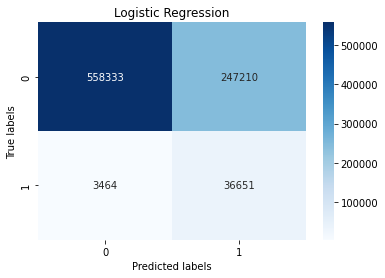

In [15]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Logistic Regression')
plt.show()